# Stage-I Distributed Mechanism Design Solution of Multi-Regional Transmission Expansion Horizontal Investment Coordination Problem

### This notebook contains codes for the three zone test case (consisting of the IEEE 14 nodes, IEEE 30 nodes, and a 5 node test system for each of the zones) for Stage-I Distributed MILP based market mechanism design to achieve the maximum value of the social surplus of the broader region

#### The first code block loads the different package dependencies to create the virtual environment in Juliaimport Pkg


First, the data from excel files are called and saved in dataframe formats.

Then, some functions are defined which can separate the lines, generators, and zones of each zone

In [1]:
using Pkg
using JuMP
using Gurobi
using GLPK
using XLSX
using DataFrames
using CSV

In [2]:
shared_cand = DataFrame(XLSX.readtable("CandLine.xlsx", "Taul1", header=true)...) #Dataframe of shared candidate lines
int_cand =  DataFrame(XLSX.readtable("CandLineInt.xlsx", "Taul1", header=true)...) #Dataframe of internal candidate lines
shared_ex =  DataFrame(XLSX.readtable("SharedEline.xlsx", "Taul1", header=true)...) #Dataframe of shared existing lines
int_ex = DataFrame(XLSX.readtable("Tran.xlsx", "Taul1", header=true)...) #Dataframe of internal existing lines
gen =  DataFrame(XLSX.readtable("Gen.xlsx" , "Taul1", header=true)...) #Dataframe of generators
load =  DataFrame(XLSX.readtable("Load.xlsx", "Taul1", header=true)...) #Dataframe of loads
scen_prob = DataFrame(XLSX.readtable("Scenario_Probability.xlsx", "Taul1", header=true)...)
zone_summary = DataFrame(CSV.File("Zone_Summary.csv", header=true)) #Dataframe of region-number of nodes

,Zone,Nodes_Total
,Int64,Int64
1,1,14
2,2,30
3,3,5


In [3]:
l(i,s) = load[load.zoneNum .== i,[1,2,s+2]] # load within zone i and scenario s
g(i) = gen[gen.zoneNum .== i, :]   # generators within zone i
shared_c(i) = vcat(shared_cand[shared_cand.nodeZone1 .== i,:] , shared_cand[shared_cand.nodeZone2 .== i, :]) #shared candidate lines within zone i
int_c(i) = int_cand[int_cand.zoneNum .== i, :]   # number of internal candidate lines within zone i
shared_e(i) = vcat(shared_ex[shared_ex.nodeZone1 .== i,:] , shared_ex[shared_ex.nodeZone2 .== i, :]) #shared existing lines within zone i
int_e(i) =int_ex[int_ex.zoneNum .== i, :]       # internal existing lines within zone i
MC(i) = (g(i).C2 .* (g(i).PgMax .^ 2) .+ g(i).C1 .* g(i).PgMax .- g(i).C2 .*(g(i).PgMin .^ 2) .- g(i).C1 .* g(i).PgMin) ./ (g(i).PgMax .- g(i).PgMin) #Marginal cost of generators within zone i
bin_c(i) = (shared_cand.nodeZone1 .== i) + (shared_cand.nodeZone2 .== i) # A binary vector through which we can check if the shared candidate lines belong to zone i
bin_e(i) = (shared_ex.nodeZone1 .== i) + (shared_ex.nodeZone2 .== i) # A binary vector through which we can check if the shared existing lines belong to zone i
scen_weight(s) = scen_prob.scen_weight[scen_prob.scenario .== s,:]

scen_weight (generic function with 1 method)

In [168]:
MC(2)

6-element Vector{Float64}:
 3.6
 3.15
 3.5
 3.667
 3.75
 4.375

As an example, the following shows the shared candidate lines that belong to zone 1:

In [4]:
shared_c(1)

,Sernum,tNodeID1,nodeZone1,tNodeID2,nodeZone2,reacT,ptMax,lifeTime,interestRate
,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,1,1,2,3,0.05917,100,50,0.05
2,3,10,1,4,3,0.19797,100,29,0.03
3,2,5,3,2,1,0.22304,100,57,0.045
4,4,19,2,14,1,0.0575,100,35,0.1


The folowing section shows the optimization problem that needs to be run by each transmission planner (TP). 
The optimization problem is written as a function of (i = the zone number, N = the number of nodes within zone i, flag = (if flag = 1, then we have binary decision variables, otherwise we have a relaxed problem), and cand_pi = the penalty vector associated with the candidate shared lines binary variables

In [86]:
function milp_hor_dist(i, N, S, flag, cand_pi, cand_mu, ex_mu)#, cand_xi)
    
    #Defining the model:
    
    Mod1 = Model(GLPK.Optimizer)
    
    #Defining variables
    
    @variable(Mod1,0 <= gen_var[1:N,1:S]) # generation at each node
    @variable(Mod1,0 <= shared_line_decision_var[1:nrow(shared_cand)] <= 1) #Decision variables for shared candidate lines
    @variable(Mod1,0 <= int_line_decision_var[1:nrow(int_c(i))] <= 1) #Decision variables for internal candidate lines
    @variable(Mod1,shared_cand_flow[1:nrow(shared_cand), 1:S])  #Power flowing into shared candidate lines 
    @variable(Mod1,int_cand_flow[1:nrow(int_c(i)), 1:S]) #Power flowing into internal candidate lines 
    @variable(Mod1, 0 <= node_voltage_phase_angle[z_index=1:nrow(zone_summary),n_index=1:zone_summary.Nodes_Total[z_index], 1:nrow(scen_prob)]<= 2*pi)
    @variable(Mod1,shared_ex_flow[1:nrow(shared_ex),1:S])  #Power flowing on shared existing shared lines
    @variable(Mod1,int_ex_flow[1:nrow(int_e(i)),1:S])  #Power flowing on internal existing lines
    
    
    #Defining the objective function
    @expression(Mod1, total_cost ,sum(scen_weight(s)[1].* (sum((gen_var[n,s] .* sum((g(i).gNodeID .== n) .* MC(i))) for n in 1:N)) for s in 1:S) 
        .+ sum(sum(shared_cand_flow[c,s] .* cand_mu[c,s] 
                #.+ node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s].* cand_xi[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] 
                #.+ node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s].* cand_xi[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s]
                .+ cand_pi[c] .* shared_line_decision_var[c].+shared_line_decision_var[c] .* shared_cand.costPerCap[c] .* shared_cand.interestRate[c] 
                .*((1 + shared_cand.interestRate[c]) .^ shared_cand.lifeTime[c]) 
                ./ (((1 + shared_cand.interestRate[c]) .^ shared_cand.lifeTime[c])-1) for c in 1:nrow(shared_cand)) for s in 1:S)
                .+ sum(int_line_decision_var[c] .* int_c(i).costPerCap[c] .* int_c(i).interestRate[c] 
                .*((1 + int_c(i).interestRate[c]) .^ int_c(i).lifeTime[c])
                ./(((1 + int_c(i).interestRate[c]) .^ int_c(i).lifeTime[c])-1) for c in 1:nrow(int_c(i)))
                .+ sum(sum(shared_ex_flow[h,s] .* ex_mu[h,s] 
                #.+ node_voltage_phase_angle[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s].* cand_xi[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s] 
                #.+ node_voltage_phase_angle[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s].* cand_xi[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s]
                for h in 1:nrow(shared_ex)) for s in 1:S))
    
    for s in 1:S
        for n in 1:N
            # Power balance constraint for each node
            @constraint(Mod1, sum((g(i).gNodeID .== n) .* gen_var[n,s]) .+ sum(l(i,s)[:,3].* (l(i,s).lNodeID .== n))./100 .==
                sum((shared_cand.tNodeID1 .== n) .*bin_c(i) .* shared_cand_flow[:,s]) .- sum((shared_cand.tNodeID2 .== n) .* bin_c(i) .* shared_cand_flow[:,s]) .+
                sum((shared_ex.tNodeID1 .== n) .* bin_e(i) .* shared_ex_flow[:,s]) .- sum((shared_ex.tNodeID2 .== n) .* bin_e(i) .* shared_ex_flow[:,s]) .+
                sum((int_c(i).tNodeID1 .== n) .* int_cand_flow[:,s]) .- sum((int_c(i).tNodeID2 .== n) .* int_cand_flow[:,s]) .+
                sum((int_e(i).tNodeID1 .== n) .* int_ex_flow[:,s]) .- sum((int_e(i).tNodeID2 .== n) .* int_ex_flow[:,s]))

        
            #Lower limit for generation of each node
            @constraint(Mod1, sum(g(i).gNodeID .== n) .* gen_var[n,s] .<= sum((g(i).gNodeID .== n) .* g(i).PgMax)./100)
            #Upper limit for generation of each node
            @constraint(Mod1, sum((g(i).gNodeID .== n) .* g(i).PgMin)./100 .<= sum(g(i).gNodeID .== n) .* gen_var[n,s])
        end
    end
    
    M=5 #Big number
    
    #Constraints elated to the candidate shared lines:
    for c in 1:nrow(shared_cand) 
        if flag==1 
            #If flag = 1, our decision variables for constructing candidate shared lines would be binary
            @constraint(Mod1, shared_line_decision_var[c] in MOI.Integer())
        end
        for s in 1:S
            #Associating the power flowing within the line with the phase angles of nodes:
            @constraint(Mod1,-M .* (1 .- shared_line_decision_var[c]) .<= shared_cand_flow[c,s] .- ((1 ./ shared_cand.reacT[c]) .* (node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] .- node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s])))
        
            @constraint(Mod1, shared_cand_flow[c,s] .- ((1 ./ shared_cand.reacT[c]) .* (node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] .- node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s])) .<= M .* (1 .- shared_line_decision_var[c]))
            #limiting the upper bound of power flow flowing within candidate shared lines
            @constraint(Mod1, shared_cand_flow[c,s] .<= shared_line_decision_var[c] .* shared_cand.ptMax[c]./100)
            #Limiting the lower bound of power flowing within the candidate shared lines
            @constraint(Mod1, -(shared_cand.ptMax[c]./100) .* shared_line_decision_var[c] .<= shared_cand_flow[c,s])
        end
    end
    
    #The same constraints related to the candidate internal lines:
    for c in 1:nrow(int_c(i))
        if flag==1
            @constraint(Mod1, int_line_decision_var[c] in MOI.Integer())
        end
        for s in 1:S
            @constraint(Mod1,-M .* (1 .- int_line_decision_var[c]) .<= int_cand_flow[c,s] .- ((1 ./ int_c(i).reacT[c]) .* (node_voltage_phase_angle[int_c(i).zoneNum[c],int_c(i).tNodeID1[c],s] .- node_voltage_phase_angle[int_c(i).zoneNum[c],int_c(i).tNodeID2[c],s])))
            @constraint(Mod1, int_cand_flow[c,s] .- ((1 ./ int_c(i).reacT[c]) .* (node_voltage_phase_angle[int_c(i).zoneNum[c],int_c(i).tNodeID1[c],s] .- node_voltage_phase_angle[int_c(i).zoneNum[c],int_c(i).tNodeID2[c],s])) .<= M .* (1 .- int_line_decision_var[c]))
            @constraint(Mod1, int_cand_flow[c,s] .<= int_line_decision_var[c] .* int_c(i).ptMax[c]./100)
            @constraint(Mod1, -(int_c(i).ptMax[c]./100) .*int_line_decision_var[c] .<= int_cand_flow[c,s])
        end
    end
    
    #The same constraints related to the shared existing lines:
    for h in 1:nrow(shared_ex)
        for s in 1:S
            @constraint(Mod1, shared_ex_flow[h,s] .== (1 ./ shared_ex.reacT[h]) .* (node_voltage_phase_angle[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s] .- node_voltage_phase_angle[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s]))
            @constraint(Mod1, shared_ex_flow[h,s] .<= shared_ex. ptMax[h]./100)
            @constraint(Mod1, -(shared_ex.ptMax[h]./100) .<= shared_ex_flow[h,s])
        end
    end
    #The same constraints related to the internal existing lines:
    
    for h in 1:nrow(int_e(i))
        for s in 1:S
            @constraint(Mod1, int_ex_flow[h,s] .== (1 ./ int_e(i).reacT[h]) .* (node_voltage_phase_angle[int_e(i).zoneNum[h],int_e(i).tNodeID1[h],s] .- node_voltage_phase_angle[int_e(i).zoneNum[h],int_e(i).tNodeID2[h],s]))
            @constraint(Mod1, int_ex_flow[h,s] .<= int_e(i).ptMax[h]./100)
            @constraint(Mod1, -(int_e(i).ptMax[h]./100) .<= int_ex_flow[h,s])
        end
    end
    
    #The model objective is to minimize the total cost:
    
    @objective(Mod1, Min, total_cost)
    optimize!(Mod1)
    if termination_status(Mod1) == MOI.OPTIMAL #If the solution is optimal then it returns the variables
    
        shared_line_decision = value.(shared_line_decision_var)
        shared_cand_power = value.(shared_cand_flow)
        shared_ex_power = value.(shared_ex_flow)
        gen_power = value.(gen_var)
        int_line_decision = value.(int_line_decision_var)
        int_cand_power = value.(int_cand_flow)
        node_voltage_phase_angles = value.(node_voltage_phase_angle)
        obj_value = objective_value(Mod1)
        [obj_value, shared_line_decision, shared_cand_power,shared_ex_power,node_voltage_phase_angles,gen_power, int_line_decision, int_cand_power]

    end
end

milp_hor_dist (generic function with 1 method)

In [87]:
function primal_problem(i, N, S, shared_line_decision_var)#, cand_xi)
    
    #Defining the model:
    flag = 1;
    
    Mod1 = Model(GLPK.Optimizer)
    
    #Defining variables
    
    @variable(Mod1,0 <= gen_var[1:N,1:S]) # generation at each node
    #@variable(Mod1,0 <= shared_line_decision_var[1:nrow(shared_cand)] <= 1) #Decision variables for shared candidate lines
    @variable(Mod1,0 <= int_line_decision_var[1:nrow(int_c(i))] <= 1) #Decision variables for internal candidate lines
    @variable(Mod1,shared_cand_flow[1:nrow(shared_cand), 1:S])  #Power flowing into shared candidate lines 
    @variable(Mod1,int_cand_flow[1:nrow(int_c(i)), 1:S]) #Power flowing into internal candidate lines 
    @variable(Mod1, 0 <= node_voltage_phase_angle[z_index=1:nrow(zone_summary),n_index=1:zone_summary.Nodes_Total[z_index], 1:nrow(scen_prob)]<= 2*pi)
    @variable(Mod1,shared_ex_flow[1:nrow(shared_ex),1:S])  #Power flowing on shared existing shared lines
    @variable(Mod1,int_ex_flow[1:nrow(int_e(i)),1:S])  #Power flowing on internal existing lines
    
    
    #Defining the objective function
    @expression(Mod1, total_cost ,sum(scen_weight(s)[1].* (sum((gen_var[n,s] .* sum((g(i).gNodeID .== n) .* MC(i))) for n in 1:N)) for s in 1:S) 
        .+ sum(sum( 
                #.+ node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s].* cand_xi[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] 
                #.+ node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s].* cand_xi[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s]
                shared_line_decision_var[c] .* shared_cand.costPerCap[c] .* shared_cand.interestRate[c] 
                .*((1 + shared_cand.interestRate[c]) .^ shared_cand.lifeTime[c]) 
                ./ (((1 + shared_cand.interestRate[c]) .^ shared_cand.lifeTime[c])-1) for c in 1:nrow(shared_cand))
                .+ sum(int_line_decision_var[c] .* int_c(i).costPerCap[c] .* int_c(i).interestRate[c] 
                .*((1 + int_c(i).interestRate[c]) .^ int_c(i).lifeTime[c])
                ./(((1 + int_c(i).interestRate[c]) .^ int_c(i).lifeTime[c])-1) for c in 1:nrow(int_c(i)))))
                #.+ node_voltage_phase_angle[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s].* cand_xi[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s] 
                #.+ node_voltage_phase_angle[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s].* cand_xi[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s]
    
    for s in 1:S
        for n in 1:N
            # Power balance constraint for each node
            @constraint(Mod1, sum((g(i).gNodeID .== n) .* gen_var[n,s]) .+ sum(l(i,s)[:,3].* (l(i,s).lNodeID .== n))./100 .==
                sum((shared_cand.tNodeID1 .== n) .*bin_c(i) .* shared_cand_flow[:,s]) .- sum((shared_cand.tNodeID2 .== n) .* bin_c(i) .* shared_cand_flow[:,s]) .+
                sum((shared_ex.tNodeID1 .== n) .* bin_e(i) .* shared_ex_flow[:,s]) .- sum((shared_ex.tNodeID2 .== n) .* bin_e(i) .* shared_ex_flow[:,s]) .+
                sum((int_c(i).tNodeID1 .== n) .* int_cand_flow[:,s]) .- sum((int_c(i).tNodeID2 .== n) .* int_cand_flow[:,s]) .+
                sum((int_e(i).tNodeID1 .== n) .* int_ex_flow[:,s]) .- sum((int_e(i).tNodeID2 .== n) .* int_ex_flow[:,s]))

        
            #Lower limit for generation of each node
            @constraint(Mod1, sum(g(i).gNodeID .== n) .* gen_var[n,s] .<= sum((g(i).gNodeID .== n) .* g(i).PgMax)./100)
            #Upper limit for generation of each node
            @constraint(Mod1, sum((g(i).gNodeID .== n) .* g(i).PgMin)./100 .<= sum(g(i).gNodeID .== n) .* gen_var[n,s])
        end
    end
    
    M=5 #Big number
    
    #Constraints elated to the candidate shared lines:
    for c in 1:nrow(shared_cand) 
        #if flag==1 
            #If flag = 1, our decision variables for constructing candidate shared lines would be binary
            #@constraint(Mod1, shared_line_decision_var[c] in MOI.Integer())
        #end
        for s in 1:S
            #Associating the power flowing within the line with the phase angles of nodes:
            @constraint(Mod1,-M .* (1 .- shared_line_decision_var[c]) .<= shared_cand_flow[c,s] .- ((1 ./ shared_cand.reacT[c]) .* (node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] .- node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s])))
        
            @constraint(Mod1, shared_cand_flow[c,s] .- ((1 ./ shared_cand.reacT[c]) .* (node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] .- node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s])) .<= M .* (1 .- shared_line_decision_var[c]))
            #limiting the upper bound of power flow flowing within candidate shared lines
            @constraint(Mod1, shared_cand_flow[c,s] .<= shared_line_decision_var[c] .* shared_cand.ptMax[c]./100)
            #Limiting the lower bound of power flowing within the candidate shared lines
            @constraint(Mod1, -(shared_cand.ptMax[c]./100) .* shared_line_decision_var[c] .<= shared_cand_flow[c,s])
        end
    end
    
    #The same constraints related to the candidate internal lines:
    for c in 1:nrow(int_c(i))
        if flag==1
            @constraint(Mod1, int_line_decision_var[c] in MOI.Integer())
        end
        for s in 1:S
            @constraint(Mod1,-M .* (1 .- int_line_decision_var[c]) .<= int_cand_flow[c,s] .- ((1 ./ int_c(i).reacT[c]) .* (node_voltage_phase_angle[int_c(i).zoneNum[c],int_c(i).tNodeID1[c],s] .- node_voltage_phase_angle[int_c(i).zoneNum[c],int_c(i).tNodeID2[c],s])))
            @constraint(Mod1, int_cand_flow[c,s] .- ((1 ./ int_c(i).reacT[c]) .* (node_voltage_phase_angle[int_c(i).zoneNum[c],int_c(i).tNodeID1[c],s] .- node_voltage_phase_angle[int_c(i).zoneNum[c],int_c(i).tNodeID2[c],s])) .<= M .* (1 .- int_line_decision_var[c]))
            @constraint(Mod1, int_cand_flow[c,s] .<= int_line_decision_var[c] .* int_c(i).ptMax[c]./100)
            @constraint(Mod1, -(int_c(i).ptMax[c]./100) .*int_line_decision_var[c] .<= int_cand_flow[c,s])
        end
    end
    
    #The same constraints related to the shared existing lines:
    for h in 1:nrow(shared_ex)
        for s in 1:S
            @constraint(Mod1, shared_ex_flow[h,s] .== (1 ./ shared_ex.reacT[h]) .* (node_voltage_phase_angle[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s] .- node_voltage_phase_angle[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s]))
            @constraint(Mod1, shared_ex_flow[h,s] .<= shared_ex. ptMax[h]./100)
            @constraint(Mod1, -(shared_ex.ptMax[h]./100) .<= shared_ex_flow[h,s])
        end
    end
    #The same constraints related to the internal existing lines:
    
    for h in 1:nrow(int_e(i))
        for s in 1:S
            @constraint(Mod1, int_ex_flow[h,s] .== (1 ./ int_e(i).reacT[h]) .* (node_voltage_phase_angle[int_e(i).zoneNum[h],int_e(i).tNodeID1[h],s] .- node_voltage_phase_angle[int_e(i).zoneNum[h],int_e(i).tNodeID2[h],s]))
            @constraint(Mod1, int_ex_flow[h,s] .<= int_e(i).ptMax[h]./100)
            @constraint(Mod1, -(int_e(i).ptMax[h]./100) .<= int_ex_flow[h,s])
        end
    end
    
    #The model objective is to minimize the total cost:
    
    @objective(Mod1, Min, total_cost)
    optimize!(Mod1)
    if termination_status(Mod1) == MOI.OPTIMAL #If the solution is optimal then it returns the variables
    
        #shared_line_decision = value.(shared_line_decision_var)
        shared_cand_power = value.(shared_cand_flow)
        shared_ex_power = value.(shared_ex_flow)
        gen_power = value.(gen_var)
        int_line_decision = value.(int_line_decision_var)
        int_cand_power = value.(int_cand_flow)
        node_voltage_phase_angles = value.(node_voltage_phase_angle)
        obj_value = objective_value(Mod1)
        [obj_value, shared_cand_power,shared_ex_power,node_voltage_phase_angles,gen_power, int_line_decision, int_cand_power]

    end
end

primal_problem (generic function with 1 method)

The above problem indicates the dual problem that should be solved by each TP. 

The second optimization problem should be solved by the marketoverseer or the transmission planner coordinator (TPC). The problem defines as a function of (fleg = 1 if we want to get binary decision variables for line construction, cand_zeta = the penalty vector associated with the candidate shared lines'phase angles, ex_zeta  = the penalty vector associated with the existing shared lines'phase angles, cand_pi = the penalty vector associated with the candidate shared lines binary variables  

In [88]:
function market_overseer(S, flag, cand_pi, cand_mu, ex_mu)#, cand_xi)
    
    #Model
    Mod2 = Model(GLPK.Optimizer)
    
    #Variables for shared candidate lines
    
    @variable(Mod2,0 <= shared_line_decision_var[1:nrow(shared_cand)] <= 1) #Decision variables
    @variable(Mod2,shared_cand_flow[1:nrow(shared_cand), 1:S]) #Flow within shared candidate lines
    @variable(Mod2, 0 <= node_voltage_phase_angle[z_index=1:nrow(zone_summary),n_index=1:zone_summary.Nodes_Total[z_index], 1:nrow(scen_prob)]<= 2*pi)
    #Variables for existing lines
    @variable(Mod2,shared_ex_flow[1:nrow(shared_ex), 1:S]) #Flow within shared existing lines
    
    #Objective function
    @expression(Mod2, mo_obj, sum((sum(shared_cand_flow[c,s] .* cand_mu[c,s] 
                    #.+ node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s].* cand_xi[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] 
                    #.+ node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s].* cand_xi[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s]
                    .+ cand_pi[c] .* shared_line_decision_var[c] for c in 1:nrow(shared_cand))
                    .+ sum(shared_ex_flow[h,s] .* ex_mu[h,s] 
                    #.+ node_voltage_phase_angle[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s].* cand_xi[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s] 
                    #.+ node_voltage_phase_angle[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s].* cand_xi[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s]
                    for h in 1:nrow(shared_ex))) for s in 1:S))
    
    M=5
    
    #Constraints related to the shared candidate lines:
    for c in 1:nrow(shared_cand)
        if flag==1
            @constraint(Mod2, shared_line_decision_var[c] in MOI.Integer())
        end
        for s in 1:S
        
            # Constraints that associate power flow with the phase angles of the nodes
            @constraint(Mod2,-M .* (1 .- shared_line_decision_var[c]) .<= shared_cand_flow[c,s] .- ((1 ./ shared_cand.reacT[c]) .* (node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] .- node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s])))
            @constraint(Mod2, shared_cand_flow[c,s] .- ((1 ./ shared_cand.reacT[c]) .* (node_voltage_phase_angle[shared_cand.nodeZone1[c],shared_cand.tNodeID1[c],s] .- node_voltage_phase_angle[shared_cand.nodeZone2[c],shared_cand.tNodeID2[c],s])) .<= M .* (1 .- shared_line_decision_var[c]))
            @constraint(Mod2, shared_cand_flow[c,s] .<=   shared_cand.ptMax[c]./100)
            #Limiting the lower bound of power flowing within the candidate shared lines
            @constraint(Mod2, -shared_cand.ptMax[c]./100  .<= shared_cand_flow[c,s])
        end
    
    end 
    #The same constraints related to the shared candidate lines:
    for h in 1:nrow(shared_ex)
        for s in 1:S
            @constraint(Mod2, shared_ex_flow[h,s] .== (1 ./ shared_ex.reacT[h]) .* (node_voltage_phase_angle[shared_ex.nodeZone1[h],shared_ex.tNodeID1[h],s] .- node_voltage_phase_angle[shared_ex.nodeZone2[h],shared_ex.tNodeID2[h],s]))
            @constraint(Mod2, shared_ex_flow[h,s] .<= shared_ex.ptMax[h]./100)
            @constraint(Mod2, -shared_ex.ptMax[h]./100 .<= shared_ex_flow[h,s])
        end
    end
    
    @objective(Mod2, Min, -mo_obj)
    optimize!(Mod2)
    
    if termination_status(Mod2) == MOI.OPTIMAL
    
        shared_line_decision = value.(shared_line_decision_var)
        shared_cand_power = value.(shared_cand_flow)
        shared_ex_power = value.(shared_ex_flow)
        node_voltage_phase_angles = value.(node_voltage_phase_angle)
        obj_value = objective_value(Mod2)

        [obj_value, shared_line_decision, shared_cand_power,shared_ex_power,node_voltage_phase_angles]
    end
end
    
    

market_overseer (generic function with 1 method)

In the following section, we define the initial values for penalty parameters

In [153]:
cand_pi_1= zeros(30000,nrow(shared_cand))


cand_pi_2 = zeros(30000,nrow(shared_cand))


cand_pi_3 = zeros(30000,nrow(shared_cand))


cand_pi_mo = zeros(30000,nrow(shared_cand))

cand_mu_1= zeros(30000,nrow(shared_cand),nrow(scen_prob))


cand_mu_2 = zeros(30000,nrow(shared_cand),nrow(scen_prob))


cand_mu_3 = zeros(30000,nrow(shared_cand),nrow(scen_prob))


cand_mu_mo = zeros(30000,nrow(shared_cand),nrow(scen_prob))

ex_mu_1= zeros(30000,nrow(shared_ex),nrow(scen_prob))


ex_mu_2 = zeros(30000,nrow(shared_ex),nrow(scen_prob))


ex_mu_3 = zeros(30000,nrow(shared_ex),nrow(scen_prob))


ex_mu_mo = zeros(30000,nrow(shared_ex),nrow(scen_prob))

#cand_xi_1 = zeros(30000,nrow(zone_summary),30, nrow(scen_prob))

#cand_xi_2 = zeros(30000,nrow(zone_summary),30, nrow(scen_prob))

#cand_xi_3 = zeros(30000,nrow(zone_summary),30, nrow(scen_prob))

#cand_xi_mo = zeros(30000,nrow(zone_summary),30, nrow(scen_prob))


30000×8×4 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0

In [154]:
#Some initial values
f=ones(12000)
u=100.01
u_new = 100.01 
low=0.001 
low_new=0.001
s=0.1 

r1_bin= ones(nrow(shared_cand)) #Initial value of zone 1 shared candidate lines decisions
r1= 0.001 * ones(nrow(shared_cand),nrow(scen_prob)) #Initial value of zone 1 shared candidate lines flow
r2_bin= ones(nrow(shared_cand)) #Initial value of zone 2 shared candidate lines decisions
r2=0.001 * ones(nrow(shared_cand),nrow(scen_prob)) #Initial value of zone 2 shared candidate lines flow
#using Random
r3_bin= ones(nrow(shared_cand)) #Initial value of zone 3 shared candidate lines decisions
r3=0.001 * ones(nrow(shared_cand),nrow(scen_prob)) #Initial value of zone 3 shared candidate lines flow
r_mo_bin=ones(nrow(shared_cand)) #Initial value of MO's shared candidate lines decisions
r_mo=0.001 * ones(nrow(shared_cand),nrow(scen_prob)) #Initial value of MO's shared candidate lines flow
r_e_1 = 0.001 * ones(zone_summary.Nodes_Total[1],nrow(scen_prob))
r_e_2 = 0.001 * ones(zone_summary.Nodes_Total[2],nrow(scen_prob))
r_e_3 = 0.001 * ones(zone_summary.Nodes_Total[3],nrow(scen_prob))
int_line_1 = zeros(nrow(int_c(1)))
int_line_2 = zeros(nrow(int_c(2)))
int_line_3 = zeros(nrow(int_c(3)))

int_line_1_flow = zeros(nrow(int_c(1)),nrow(scen_prob))
int_line_2_flow = zeros(nrow(int_c(2)),nrow(scen_prob))
int_line_3_flow = zeros(nrow(int_c(3)),nrow(scen_prob))

gen_1 = zeros(nrow(g(1)),nrow(scen_prob))
gen_2 = zeros(nrow(g(2)),nrow(scen_prob))
gen_3 = zeros(nrow(g(3)),nrow(scen_prob))

r_e1 = zeros(nrow(shared_ex),nrow(scen_prob))
r_e2 = zeros(nrow(shared_ex),nrow(scen_prob))
r_e3 = zeros(nrow(shared_ex),nrow(scen_prob))
u_new_plot = zeros(1000)
low_new_plot = zeros(1000)
f_plot = zeros(1000)
f_diff_plot = zeros(1000)
f_sum_plot = zeros(1000)
iter = 0

0

In [155]:
j = 2
max_iter = 800
for j in 2:max_iter    # It considers 1000 iteration
        if abs(f[j-1]) > 0.0005
        #f_sum += f
         #Solving the relaxed optimization problem (lower bound) for zone 1
        R1_1_l = milp_hor_dist(1, 14, 4, 0, cand_pi_1[j,:], cand_mu_1[j,:,:], ex_mu_1[j,:,:])#, cand_xi_1[j,:,:,:])
            #Solving the relaxed optimization problem for zone 2
        R1_2_l = milp_hor_dist(2, 30, 4, 0, cand_pi_2[j,:], cand_mu_2[j,:,:], ex_mu_2[j,:,:])#, cand_xi_2[j,:,:,:])
            #Solving the relaxed optimization problem for zone 3
        R1_3_l = milp_hor_dist(3, 5, 4, 0, cand_pi_3[j,:], cand_mu_3[j,:,:], ex_mu_3[j,:,:])#, cand_xi_3[j,:,:,:])
            #Solving the optimization problem of the market overseer
        R2_l = market_overseer(4,0,cand_pi_mo[j,:,:], cand_mu_mo[j,:,:], ex_mu_mo[j,:,:])#, cand_xi_mo[j,:,:,:])

            #Solving the optimization problem for zone 1
        R1_1_u = milp_hor_dist(1, 14, 4, 1, cand_pi_1[j,:], cand_mu_1[j,:,:], ex_mu_1[j,:,:])#, cand_xi_1[j,:,:,:])
            #Solving the optimization problem for zone 2
        R1_2_u = milp_hor_dist(2, 30, 4, 1, cand_pi_2[j,:], cand_mu_2[j,:,:], ex_mu_2[j,:,:])#, cand_xi_2[j,:,:,:])
            #Solving the optimization problem for zone 3
        R1_3_u = milp_hor_dist(3, 5, 4, 1, cand_pi_3[j,:], cand_mu_3[j,:,:], ex_mu_3[j,:,:])#, cand_xi_3[j,:,:,:])
            #Solving the relaxed optimization problem for MO
        R2_u = market_overseer(4,1,cand_pi_mo[j,:,:], cand_mu_mo[j,:,:], ex_mu_mo[j,:,:])#, cand_xi_mo[j,:,:,:])

        

        #Updating cand_pi for each zone and MO based on the results of shared candidate lines' decision variables
        cand_pi_1[j+1,:] .= bin_c(1) .* cand_pi_1[j,:] .+ bin_c(1) .* (0.01 *(R1_1_u[2] .- R2_u[2]))
        cand_pi_2[j+1,:] .= bin_c(2) .* cand_pi_2[j,:] .+ bin_c(2) .* (0.01 *(R1_2_u[2] .- R2_u[2])) 
        cand_pi_3[j+1,:] .= bin_c(3) .* cand_pi_3[j,:] .+ bin_c(3) .* (0.01 *(R1_3_u[2] .- R2_u[2])) 
        #cand_pi_1[j+1,:] .= bin_c(1) .* cand_pi_1[j,:] .+ bin_c(1) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_1_u[2] .- R2_u[2])) 
        #cand_pi_2[j+1,:] .= bin_c(2) .* cand_pi_2[j,:] .+ bin_c(2) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_2_u[2] .- R2_u[2])) 
        #cand_pi_3[j+1,:] .= bin_c(3) .* cand_pi_3[j,:] .+ bin_c(3) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_3_u[2] .- R2_u[2])) 
        cand_pi_mo[j+1,:] .= (cand_pi_1[j,:] .+ cand_pi_2[j,:] .+  cand_pi_3[j,:])  

        cand_mu_1[j+1,:,:] .= bin_c(1) .* cand_mu_1[j,:,:] .+ bin_c(1) .* ((0.01).* (R1_1_u[3] .- R2_u[3])) 
        cand_mu_2[j+1,:,:] .= bin_c(2) .* cand_mu_2[j,:,:] .+ bin_c(2) .* ((0.01).* (R1_2_u[3] .- R2_u[3]))
        cand_mu_3[j+1,:,:] .= bin_c(3) .* cand_mu_3[j,:,:] .+ bin_c(3) .* ((0.01).* (R1_3_u[3] .- R2_u[3])) 
        #cand_mu_1[j+1,:,:] .= bin_c(1) .* cand_mu_1[j,:,:] .+ bin_c(1) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_1_u[3] .- R2_u[3])) 
        #cand_mu_2[j+1,:,:] .= bin_c(2) .* cand_mu_2[j,:,:] .+ bin_c(2) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_2_u[3] .- R2_u[3]))
        #cand_mu_3[j+1,:,:] .= bin_c(3) .* cand_mu_3[j,:,:] .+ bin_c(3) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_3_u[3] .- R2_u[3])) 
        cand_mu_mo[j+1,:,:] .=  (cand_mu_1[j,:,:] .+ cand_mu_2[j,:,:] .+  cand_mu_3[j,:,:]) 

        ex_mu_1[j+1,:,:] .= bin_e(1) .* ex_mu_1[j,:,:] .+ bin_e(1) .* ((0.01).* (R1_1_u[4] .- R2_u[4])) 
        ex_mu_2[j+1,:,:] .= bin_e(2) .* ex_mu_2[j,:,:] .+ bin_e(2) .* ((0.01).* (R1_2_u[4] .- R2_u[4])) 
        ex_mu_3[j+1,:,:] .= bin_e(3) .* ex_mu_3[j,:,:] .+ bin_e(3) .* ((0.01).* (R1_3_u[4] .- R2_u[4])) 
        #ex_mu_1[j+1,:,:] .= bin_e(1) .* ex_mu_1[j,:,:] .+ bin_e(1) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_1_u[4] .- R2_u[4])) 
        #ex_mu_2[j+1,:,:] .= bin_e(2) .* ex_mu_2[j,:,:] .+ bin_e(2) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_2_u[4] .- R2_u[4])) 
        #ex_mu_3[j+1,:,:] .= bin_e(3) .*  ex_mu_3[j,:,:] .+ bin_e(3) .* ((0.01 *(f)+0.005*abs(f_diff)+0.001*abs(f_sum)).* (R1_3_u[4] .- R2_u[4])) 
        ex_mu_mo[j+1,:,:] .= (ex_mu_1[j,:,:] .+ ex_mu_2[j,:,:] .+  ex_mu_3[j,:,:]) 
        
        #cand_xi_1[j+1,:,:,:] .= cand_xi_1[j,:,:,:] .+ (0.01 * (R1_1_u[5] .- R2_u[5])) 
        #cand_xi_2[j+1,:,:,:] .= cand_xi_2[j,:,:,:] .+ (0.01 * (R1_2_u[5] .- R2_u[5])) 
        #cand_xi_3[j+1,:,:,:] .= cand_xi_3[j,:,:,:] .+ (0.01 * (R1_3_u[5] .- R2_u[5])) 
        #cand_xi_mo[j+1,:,:,:] .= (cand_xi_1[j+1,:,:,:] .+ cand_xi_2[j+1,:,:,:] .+  cand_xi_3[j+1,:,:,:])
        
        #solving the primal problem with MO decision variables for zone 1
        P1_1_u = primal_problem(1, 14, 4, R2_u[2])
        #solving the primal problem with MO decision variables for zone 2
        P1_2_u = primal_problem(2, 30, 4, R2_u[2])
        #solving the primal problem with MO decision variables for zone 3
        P1_3_u = primal_problem(3, 5, 4, R2_u[2])


        #u = the sum of objective values after solving the zonal optimization problem
        u_new = P1_1_u[1] + P1_2_u[1] + P1_3_u[1]

        #low = the sum of objective values after solving the relaxed zonal optimization problem
        low_new = R1_1_l[1] + R1_2_l[1] + R1_3_l[1] + R2_l[1]
        #f_old = f
        #Stopping criterion
        f[j] = 1 - (low_new / u_new)
        #f_new = f
        #f_diff = f_new-f_old
        #u_new_plot[j] = u_new
        #low_new_plot[j] = low_new
        #f_plot[j] = f
        #f_diff_plot[j] = f_diff
        #f_sum_plot[j] = f_sum
        r1_bin = R1_1_u[2]
        r1 = R1_1_u[3]
        r2_bin = R1_2_u[2]
        r2 = R1_2_u[3]
        r3_bin = R1_3_u[2]
        r3 = R1_3_u[3]
        r_mo_bin = R2_u[2]
        r_mo = R2_u[3]
        r_e_1 = R1_1_u[5]
        r_e_2 = R1_2_u[5]
        r_e_3 = R1_3_u[5]
        r_e1 = R1_1_u[4]
        r_e2 = R1_2_u[4]
        r_e3 = R1_3_u[4]
        int_line_1 = R1_1_u[7]
        int_line_2 = R1_2_u[7]
        int_line_3 = R1_3_u[7]
        int_line_1_flow = R1_1_u[8]
        int_line_2_flow = R1_2_u[8]
        int_line_3_flow = R1_3_u[8]
        gen_1 = R1_1_u[6]
        gen_2 = R1_2_u[6]
        gen_3 = R1_3_u[6]
            print('*') 

    else
        iter = j-1
        print(iter)
            #If our criterion is met, then print these values:
        print(low_new)
        print(u_new)
        print(int_line_1)
        print(int_line_2)
        print(int_line_3)
        print(j)
        print(f) #criterion
        print(r1_bin) #binary decisions of shared candidate lines (zone 1)
        print(r1) # power flow of shared candidate lines (zone 1)
        print(r2_bin) #binary decisions of shared candidate lines (zone 2)
        print(r2) # power flow of shared candidate lines (zone 2)
        print(r3_bin) #binary decisions of shared candidate lines (zone 3)
        print(r3) # power flow of shared candidate lines (zone 3)
        print(r_mo_bin)  #binary decisions of shared candidate lines (MO)
        print(r_mo) # power flow of shared candidate lines (MO)
        print(r_e_1) # angle of existing candidate lines (zone 1)
        print(r_e_2)  # angle of existing candidate lines (zone 2)
        print(r_e_3) # angle of existing candidate lines (zone 3)
        break
    end
end



*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [156]:
if iter == 0
    iter = max_iter
end

800

In [157]:
u_new

14.605479724478036

In [158]:
print(bin_c(1))
print(bin_c(2))
print(bin_c(3))

[1, 1, 1, 1, 0, 0][0, 0, 0, 1, 1, 1][1, 1, 1, 0, 1, 1]

In [159]:
f[iter] #The criteria

0.04426674619697124

In [160]:
r1_bin

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0

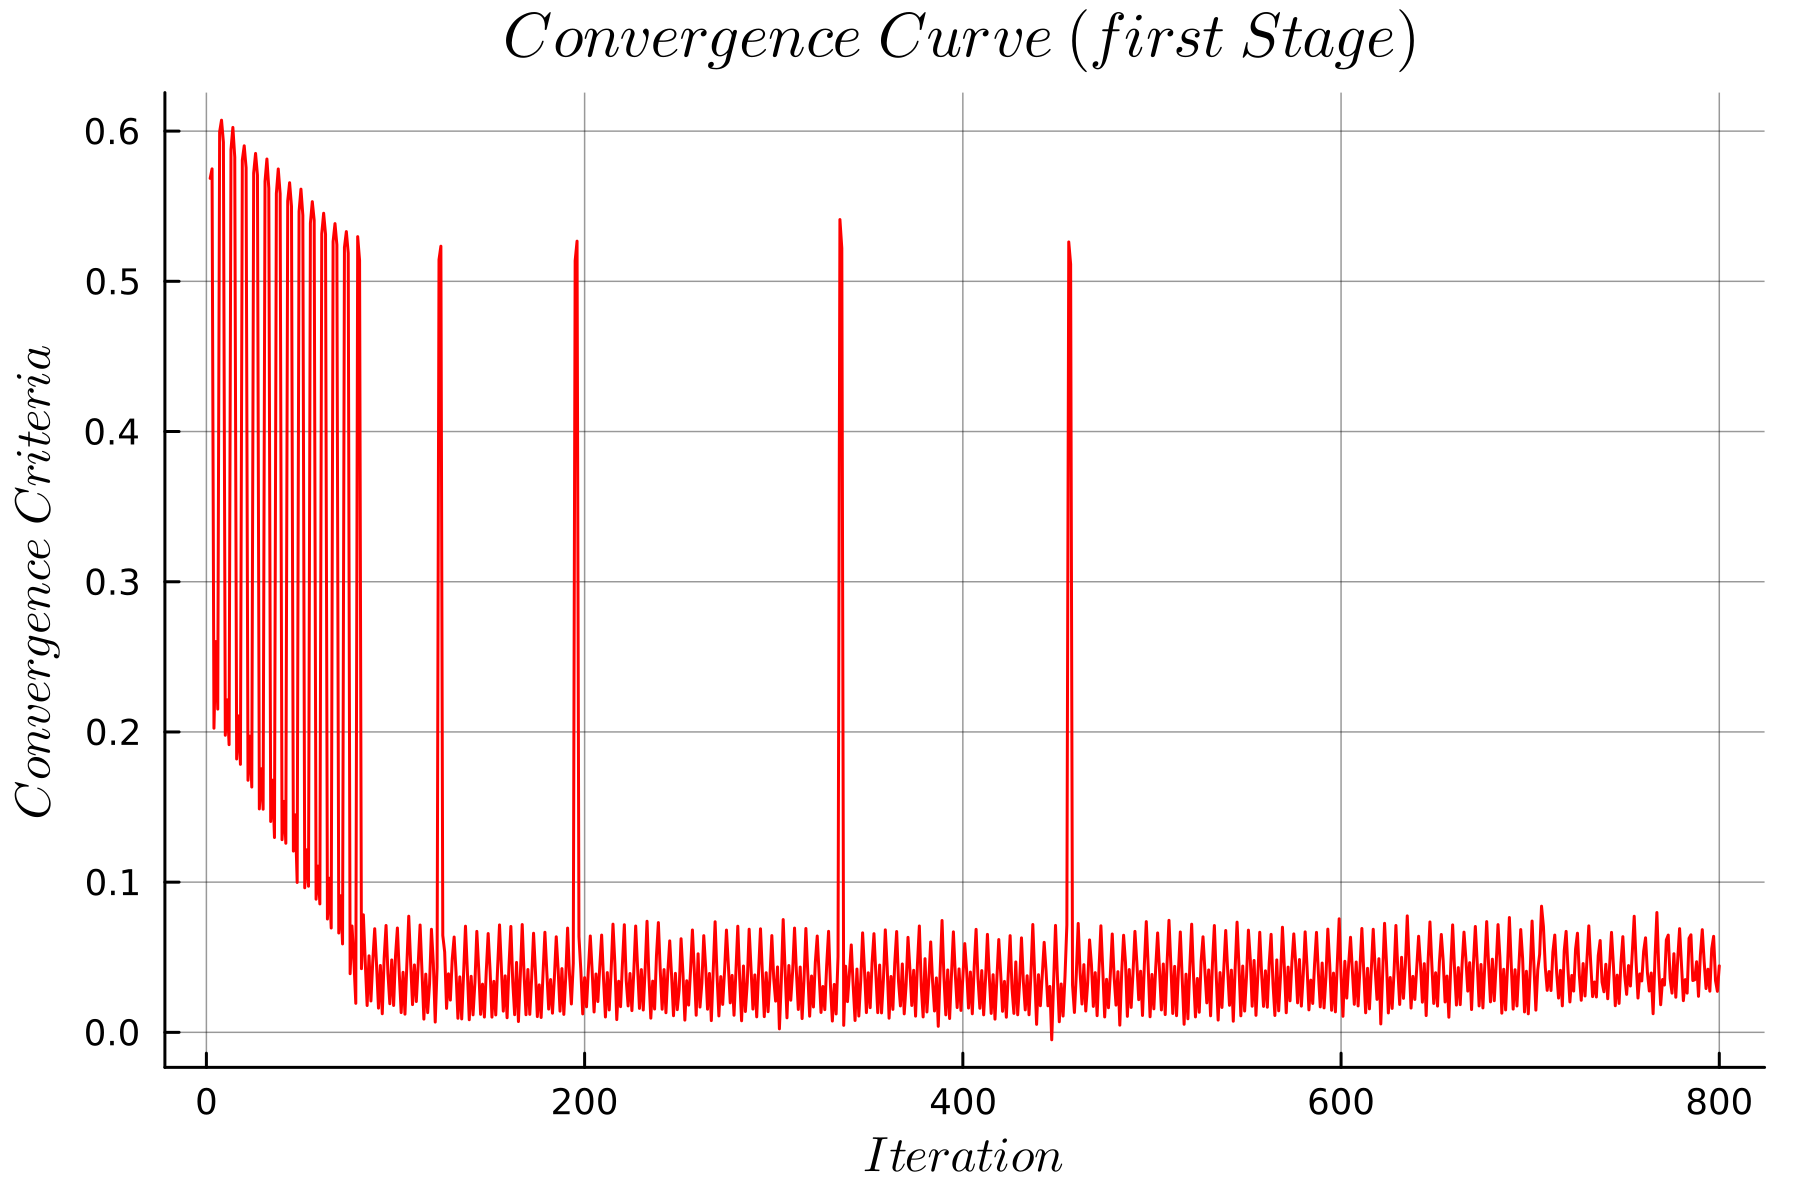

In [161]:
#using Plots
#plot(2:iter,f[2:iter])
using Plots, LaTeXStrings
plot(2:iter, f[2:iter], dpi=300, linewidth=1, color=:red, grid=true, gridalpha= 0.4,
     title = L"Convergence \ Curve \ (first \ Stage)",
    label= false,
     xlabel = L"Iteration",
     ylabel = L"Convergence \ Criteria",fmt = :png)
#scatter!([2,200,400,600,800,1000], f[[2,200,400,600,800,1000]],
    #label = false, mc=:blue, ms=5, ma=0.5, fmt = :png)

In [162]:
r2_bin

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0

In [163]:
r3_bin #Binary decisions for constructing shared lines solved by TP 3

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [164]:
r_mo_bin #Binary decisions for constructing shared lines solved by TPC or MO

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0

In [128]:
r1 .* 100 #The value obtained by TP 1 and indicating the power flowing into the shared lines

6×4 Matrix{Float64}:
   0.0   0.0       0.0   0.0
   0.0   0.0       0.0   0.0
   0.0   0.0       0.0   0.0
 100.0  88.6312  100.0  35.7056
   0.0   0.0       0.0   0.0
   0.0   0.0       0.0   0.0

In [129]:
r2 .* 100  #The value obtained by TP 2 and indicating the power flowing into the shared lines

6×4 Matrix{Float64}:
   0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0
 100.0  100.0  100.0  100.0
   0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0

In [130]:
r3 .* 100  #The value obtained by TP 1 and indicating the power flowing into the shared lines

6×4 Matrix{Float64}:
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  2.42029e-12  -1.69864e-12   2.42029e-12  -1.15463e-12
  0.0           0.0           0.0           0.0
 -0.0           1.47091e-14  -1.47091e-14   1.47091e-14
  1.55431e-13   1.55431e-13   1.55431e-13   1.55431e-13

In [131]:
r_e_1

JuMP.Containers.SparseAxisArray{Float64, 3, Tuple{Int64, Int64, Int64}} with 196 entries:
  [1, 1, 1 ]  =  0.11581
  [1, 1, 2 ]  =  0.608401
  [1, 1, 3 ]  =  1.23241
  [1, 1, 4 ]  =  0.527288
  [1, 10, 1]  =  0.273109
  [1, 10, 2]  =  0.552879
  [1, 10, 3]  =  1.43422
  [1, 10, 4]  =  0.596982
  [1, 11, 1]  =  0.253055
  [1, 11, 2]  =  0.531153
              ⋮
  [3, 3, 2 ]  =  0.0
  [3, 3, 3 ]  =  0.0
  [3, 3, 4 ]  =  0.0
  [3, 4, 1 ]  =  0.627581
  [3, 4, 2 ]  =  0.0
  [3, 4, 3 ]  =  1.83009
  [3, 4, 4 ]  =  0.0
  [3, 5, 1 ]  =  0.11
  [3, 5, 2 ]  =  0.11
  [3, 5, 3 ]  =  0.11
  [3, 5, 4 ]  =  0.11

In [132]:
r_e_2

JuMP.Containers.SparseAxisArray{Float64, 3, Tuple{Int64, Int64, Int64}} with 196 entries:
  [1, 1, 1 ]  =  0.2679
  [1, 1, 2 ]  =  0.2679
  [1, 1, 3 ]  =  0.2679
  [1, 1, 4 ]  =  0.755136
  [1, 10, 1]  =  0.114085
  [1, 10, 2]  =  0.59583
  [1, 10, 3]  =  0.0942761
  [1, 10, 4]  =  0.738767
  [1, 11, 1]  =  0.0
  [1, 11, 2]  =  0.0
              ⋮
  [3, 3, 2 ]  =  0.214086
  [3, 3, 3 ]  =  0.261319
  [3, 3, 4 ]  =  0.262821
  [3, 4, 1 ]  =  0.0
  [3, 4, 2 ]  =  0.0
  [3, 4, 3 ]  =  0.0
  [3, 4, 4 ]  =  0.0
  [3, 5, 1 ]  =  0.692089
  [3, 5, 2 ]  =  0.546192
  [3, 5, 3 ]  =  0.533165
  [3, 5, 4 ]  =  0.63879

In [133]:
r_e_3

JuMP.Containers.SparseAxisArray{Float64, 3, Tuple{Int64, Int64, Int64}} with 196 entries:
  [1, 1, 1 ]  =  0.3456
  [1, 1, 2 ]  =  0.2679
  [1, 1, 3 ]  =  0.397333
  [1, 1, 4 ]  =  0.2679
  [1, 10, 1]  =  0.0
  [1, 10, 2]  =  0.0
  [1, 10, 3]  =  0.0
  [1, 10, 4]  =  0.0
  [1, 11, 1]  =  0.0
  [1, 11, 2]  =  0.0
              ⋮
  [3, 3, 2 ]  =  0.125129
  [3, 3, 3 ]  =  0.586
  [3, 3, 4 ]  =  0.137086
  [3, 4, 1 ]  =  0.556
  [3, 4, 2 ]  =  0.113621
  [3, 4, 3 ]  =  0.556
  [3, 4, 4 ]  =  0.126189
  [3, 5, 1 ]  =  0.5176
  [3, 5, 2 ]  =  0.0829357
  [3, 5, 3 ]  =  0.742667
  [3, 5, 4 ]  =  0.0971321

In [134]:
u_new

14.605479724478036

In [135]:
low_new

13.801853625614514

In [136]:
int_line_1

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [137]:
int_line_2

18-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [138]:
int_line_3

2-element Vector{Float64}:
 0.0
 0.0

In [139]:
gen_1 .* 100 

14×4 Matrix{Float64}:
 83.5666  0.0  18.2976  0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0
  0.0     0.0   0.0     0.0

In [140]:
show(stdout, "text/plain", gen_2 .* 100 )

30×4 Matrix{Float64}:
  0.0   0.0          21.9           0.0
 69.2  80.0          80.0          47.3
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
 40.0  14.6          40.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0           0.0           0.0
 50.0  -6.66134e-13  -1.31006e-12   0.0
 30.0  -1.52595e-14   0.0           0.0
  0.0   0.0           0.0           0.0
  0.0   0.0       

In [141]:
gen_3 .* 100 

5×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [142]:
int_line_1_flow .* 100 

10×4 Matrix{Float64}:
  0.0   0.0   0.0  -0.0
 -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0  -0.0
 -0.0   0.0  -0.0  -0.0
  0.0  -0.0   0.0   0.0
 -0.0  -0.0  -0.0   0.0
  0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0
 -0.0   0.0   0.0  -0.0
  0.0  -0.0   0.0  -0.0

In [143]:
int_line_2_flow .* 100 

18×4 Matrix{Float64}:
  0.0           0.0          -3.33067e-14   0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
 -3.10862e-13  -3.10862e-13  -3.10862e-13  -3.10862e-13
 -3.10862e-13  -3.10862e-13   3.10862e-13   3.10862e-13
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
  0.0           0.0           0.0           0.0
 -0.0          -0.0          -0.0          -0.0
  0.0           0.0           0.0           0.0

In [144]:
int_line_3_flow .* 100 

2×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [145]:
r_e1

8×4 Matrix{Float64}:
  0.754334   0.408688   0.759524   0.290444
 -1.0        0.841888  -1.0        1.0
  1.0       -1.0        1.0        1.0
  0.900599  -1.0        1.0       -1.0
 -0.421952   0.658618  -0.24802   -0.425737
 -1.0       -1.0       -1.0       -1.0
 -1.0       -1.0       -1.0       -1.0
 -1.0       -1.0       -1.0       -1.0

In [146]:
r_e2

8×4 Matrix{Float64}:
  0.725086     0.311362   0.338626   0.877499
 -1.0          0.293997  -1.0        0.421721
 -1.0         -1.0       -1.0       -1.0
 -1.0         -1.0       -1.0       -1.0
 -1.0         -1.0       -1.0       -1.0
  1.0          1.0        1.0       -1.0
  0.00541234   1.0        1.0        0.69069
 -0.850534    -0.617875  -0.556175  -1.0

In [147]:
r_e3

8×4 Matrix{Float64}:
 -1.0   -1.0    -1.0       -1.0
 -1.0   -1.0    -1.0       -1.0
  1.0   -1.0     1.0       -1.0
  1.0   -1.0     1.0       -1.0
 -0.35  -1.0    -0.663889  -1.0
  1.0    0.825   1.0        0.4125
 -1.0    1.0     1.0        1.0
 -1.0   -1.0    -0.901389  -1.0